# Setup

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

# Instantiate a brand new model

In [2]:
# tokenizer
from tokenizers.bpe.tokenizer import get_tokenizer
tokenizer = get_tokenizer(size = 2048) # size options are 95(character-wise), 128, 256, 512, 1024, 2048 & 4096

# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
cfg.vocab_len = tokenizer.vocab_len
tcfg = TrainConfig()
print(cfg, '\n\n', tcfg)

# model modules
from modules.model import Model
model = Model(cfg).to(cfg.device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters\n')
print(model)

ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=4, second_resid_norm=False, mlp_hidden_mult=2.666, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=4, num_kv_heads=1, head_dim=16, theta=10000, max_seq_len=256, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 TrainConfig(weight_decay=0.02, batch_size=32, max_iters=100, eval_interval=10, eval_samples=1, checkpoint_interval=None, lr_init=1e-05, lr_max=0.1, lr_min=0.001, warmup_iters=10, final_flat_iters=10, anneal_type='cos', num_restarts=3, T_mult=2)
303.936 K parameters

Model(
  (token_embedder): Embedding(2051, 64)
  (layers): ModuleList(
    (0-3): 4 x Layer(
      (pre_attn_norm): Norm()
      (attn): MQA(
        (Wq): Linear(in_features=64, out_features=64, bias=False)
        (Wk): Linear(in_features=64, out_features=16, bias=False)
        (Wv): Linear(in_features=64, out_features=16, bias=False)
        (Wo): Linear(in_features=64, ou

# Training

In [3]:
import torch
from tools import get_data_loader
from train import scheduler_lambda, train

optimizer = torch.optim.AdamW(model.parameters(), lr = tcfg.lr_max, weight_decay = tcfg.weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler_lambda)

train_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='train')
test_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='validation')

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


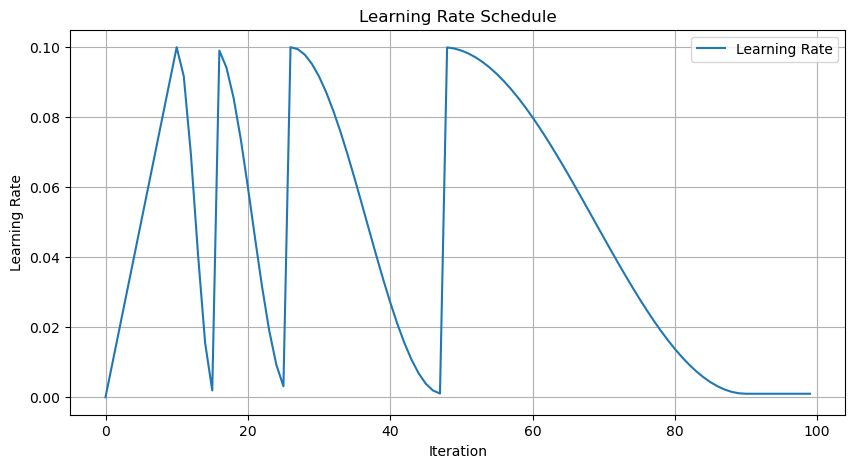

In [4]:
if True: # set to true if you'd like to see a graph of the learning rate schedule
    import matplotlib.pyplot as plt
    
    # Generate learning rate values
    lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
    # Plot the learning rates
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
model, optimizer, log_data = train(
    model, 
    tokenizer, 
    cfg, 
    optimizer,
    scheduler,
    tcfg, 
    train_data_loader,
    test_data_loader,
    #log_data: list = None, 
    #detect_anomoly = False # use if you're getting crazy errors about a the gradient being broken
)

  1%|▏              | 1/100 [00:01<02:14,  1.36s/it]

step 0000: lr 0.000001, train loss 64.3947, val loss 63.9930, ppl 6191348302329422880675201024, time elapsed: 0.91 seconds


 11%|█▌            | 11/100 [00:05<00:47,  1.86it/s]

step 0010: lr 0.010000, train loss 20.1438, val loss 20.4077, ppl 729367424, time elapsed: 5.46 seconds


 21%|██▉           | 21/100 [00:10<00:45,  1.73it/s]

step 0020: lr 0.006016, train loss 11.2957, val loss 11.3549, ppl 85382, time elapsed: 10.35 seconds


 31%|████▎         | 31/100 [00:15<00:45,  1.52it/s]

step 0030: lr 0.009166, train loss 8.4066, val loss 8.1146, ppl 3343, time elapsed: 15.30 seconds


 41%|█████▋        | 41/100 [00:20<00:33,  1.76it/s]

step 0040: lr 0.002717, train loss 6.7936, val loss 6.8067, ppl 904, time elapsed: 20.11 seconds


 51%|███████▏      | 51/100 [00:25<00:27,  1.78it/s]

step 0050: lr 0.009905, train loss 6.1987, val loss 6.2523, ppl 519, time elapsed: 24.85 seconds


 61%|████████▌     | 61/100 [00:29<00:21,  1.82it/s]

step 0060: lr 0.007999, train loss 5.4533, val loss 5.4501, ppl 233, time elapsed: 29.47 seconds


 71%|█████████▉    | 71/100 [00:34<00:16,  1.78it/s]

step 0070: lr 0.004565, train loss 5.1180, val loss 5.1877, ppl 179, time elapsed: 34.24 seconds


 81%|███████████▎  | 81/100 [00:39<00:10,  1.80it/s]

step 0080: lr 0.001382, train loss 5.0362, val loss 4.9708, ppl 144, time elapsed: 38.89 seconds


 91%|████████████▋ | 91/100 [00:43<00:04,  1.83it/s]

step 0090: lr 0.000100, train loss 5.0285, val loss 5.0464, ppl 155, time elapsed: 43.48 seconds


100%|█████████████| 100/100 [00:48<00:00,  2.08it/s]

step 0099: lr 0.000100, train loss 4.9719, val loss 5.0352, ppl 154, time elapsed: 47.71 seconds


# inference test before you decide to save it

In [6]:
from inference import generate
prompt = "Once upon a time"
model.eval()
output = generate(
    prompt, 
    model, 
    tokenizer,
    #max_gen_len = 512,
    temperature = 0.7,
    #memory_saver_div = 8,
    #top_p = 0.9,
    #top_k = 32,
)
model.train()
print(output)

Once upon a time.
t . The  lked meut d a big ing. The er, there n,  t  ndeedd gethe papisn ther ae t on  ved d  to t ittshle the cothere was ce o  h isand a of the s and to d caoutm he ple. The o , the n, the so he was halthe was was withe was a was sre nt a  was in thertr and the on on ther to  gThe . They. It opwe ved on the t up was hre ted her to  n day, the was t , "a  to . The  tomeled a reand , ther was swilym  c was  was was a  ladhery the ism he h lamo . The , the was was was ar n, 


# Saving your final model
if `tcfg.checkpoint_interval != None` then checkpoints have already been saved

you DO still need to do this even if you had been saving checkpoints; the final state has not yet been saved

In [7]:
from tools import save_model
save_model(model, cfg, tcfg, log_data)